# Forecasting Analysis

This analyis was conducted to predict for the occurrence of downtime within the next week of the time period provided in the source dataset.

## Contents
- [Import Packages and Load Data](#Import-Packages-and-Load-Data)
- [Build a Model and Build Future Data](#Build-a-Model-and-Build-Future-Data)
- [Plot Forecast](#Plot-Forecast)
- [Forecasted Change and Uncertainty](#Forecasted-Change-and-Uncertainty)
- [Conclusion](#Conclusion)

## Import Packages and Load Data

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet

In [3]:
# Load the sheets
xls = pd.ExcelFile(r'../phase-1/clean_data_final.xlsx')
line_downtime_df = xls.parse('Line_downtime')
line_productivity_df = xls.parse('Line_productivity')

# Merge on 'Batch'
merged_df = pd.merge(line_downtime_df, line_productivity_df[['Batch', 'Date']], on='Batch', how='left')

# Convert date to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Group by Date and sum Minutes
daily_downtime = merged_df.groupby('Date')['Minutes'].sum().reset_index()
daily_downtime = daily_downtime.sort_values('Date')

print(daily_downtime.head())

        Date  Minutes
0 2024-08-29      244
1 2024-08-30      444
2 2024-08-31      165
3 2024-09-02      503
4 2024-09-03       32


## Build a Model and Build Future Data

In [6]:
# Step 1: Prepare data
prophet_df = daily_downtime.rename(columns={'Date': 'ds', 'Minutes': 'y'})

In [7]:
# Step 2: Initialize and fit model
model = Prophet()
model.fit(prophet_df)

01:30:26 - cmdstanpy - INFO - Chain [1] start processing
01:30:26 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Step 3: Make future dataframe
future = model.make_future_dataframe(periods=7)  # Forecast next 7 days

In [9]:
# Step 4: Generate forecast
forecast = model.predict(future)

## Plot Forecast

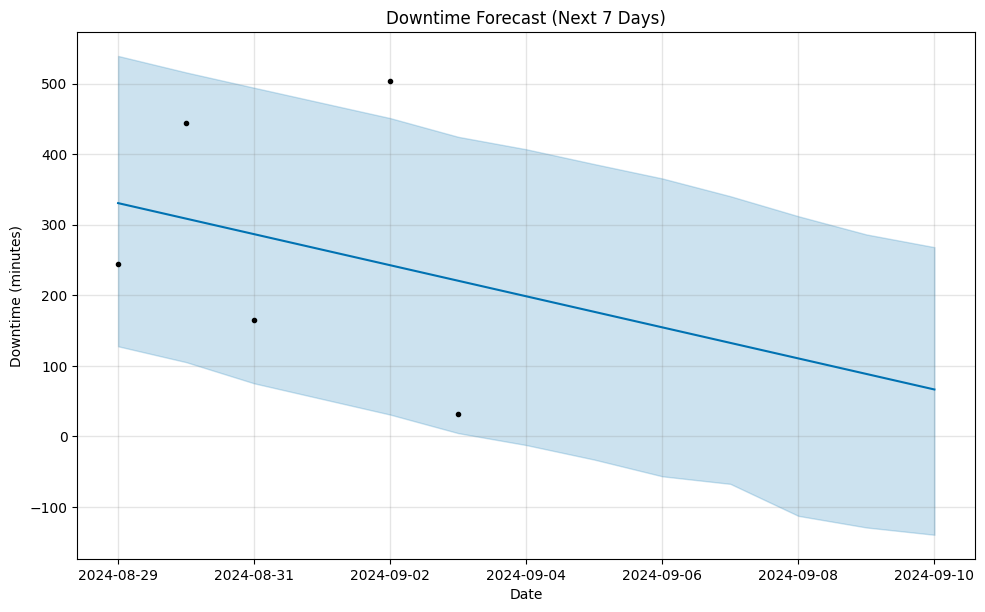

In [10]:
model.plot(forecast)
plt.title("Downtime Forecast (Next 7 Days)")
plt.xlabel("Date")
plt.ylabel("Downtime (minutes)")
plt.show()

## Forecasted Change and Uncertainty

In [12]:
# Recent actual downtime (last 7 days in your data)
recent_actual = prophet_df.tail(7)['y'].sum()

# Forecasted downtime (next 7 days from the forecast)
future_forecast = forecast[forecast['ds'] > prophet_df['ds'].max()]
next_7_days_forecast = future_forecast.head(7)['yhat'].sum()

# Calculate percentage change
change_pct = ((next_7_days_forecast - recent_actual) / recent_actual) * 100

print(f"Forecasted change in downtime: {change_pct:.2f}%")

Forecasted change in downtime: -33.22%


In [13]:
# Calculate uncertainty width for each day
future_forecast['uncertainty_width'] = future_forecast['yhat_upper'] - future_forecast['yhat_lower']

# Show a few examples
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'uncertainty_width']].head())

          ds        yhat  yhat_lower  yhat_upper  uncertainty_width
5 2024-09-04  198.445572  -12.419101  406.850683         419.269784
6 2024-09-05  176.432783  -33.022098  385.851778         418.873876
7 2024-09-06  154.419994  -56.682683  365.470867         422.153550
8 2024-09-07  132.407205  -67.407460  340.310774         407.718234
9 2024-09-08  110.394416 -112.764547  311.932867         424.697414


C:\Users\abdul\AppData\Local\Temp\ipykernel_22724\2319188983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['uncertainty_width'] = future_forecast['yhat_upper'] - future_forecast['yhat_lower']


## Conclusion

- Downtime is forecasted to drop by 33.22%.
- There is a high level of uncertainty in the forecast results probably because the size of the historical data is very small.